In [ ]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [140]:
# data cleaning and exploration
df_wdi = pd.read_csv(r"C:\Users\Usuario\Documents\GitHub\Beta-Convergence-Analysis-of-Country-Growth\data\wdi_data.csv", sep=";", decimal=',')

df_wdi.columns = [col.split(' [')[0] if ' [' in col else col for col in df_wdi.columns]
df_wdi = df_wdi.dropna()

print(df_wdi.isnull().sum())
print(df_wdi.describe().round(3))
print(df_wdi.head())

Country Code    0
2004            0
2005            0
2006            0
2007            0
2008            0
2009            0
2010            0
2011            0
2012            0
2013            0
2014            0
2015            0
2016            0
2017            0
2018            0
2019            0
2020            0
2021            0
2022            0
2023            0
2024            0
dtype: int64
         2004    2005    2006    2007    2008    2009    2010    2011    2012  \
count  30.000  30.000  30.000  30.000  30.000  30.000  30.000  30.000  30.000   
mean    3.213   2.997   3.704   3.527   1.416  -0.970   2.897   2.159   1.547   
std     1.863   1.890   2.204   2.281   2.879   4.082   2.469   2.306   2.394   
min     0.310   0.430   0.130   0.370  -6.410  -8.510  -0.980  -1.180  -2.930   
25%     1.902   1.842   1.680   1.748  -0.805  -4.505   0.883   0.438  -0.003   
50%     3.050   2.380   3.590   3.010   1.520  -0.435   2.435   1.570   1.380   
75%     4.715   3.792   

In [209]:
# data partitioning
df_wdi['Pre_Crisis_Growth (2004-2008)'] = df_wdi.loc[:, '2004':'2008'].mean(axis=1, skipna=True) # not .iloc (string cols)
df_wdi['Recuperation_Growth (2009-2013)'] = df_wdi.loc[:, '2009':'2013'].mean(axis=1, skipna=True)
df_wdi['Stability_Growth (2014-2018)'] = df_wdi.loc[:, '2014':'2018'].mean(axis=1, skipna=True)
df_wdi['Recent_Growth (2019-2024)'] = df_wdi.loc[:, '2019':'2024'].mean(axis=1, skipna=True)

results = df_wdi[['Country Code', 'Pre_Crisis_Growth (2004-2008)', 'Recuperation_Growth (2009-2013)', 
                  'Stability_Growth (2014-2018)', 'Recent_Growth (2019-2024)']].round(2)

# group by country code            
emerging = ['CHL', 'POL', 'ETH', 'VNM', 'IND', 'EGY', 'IDN', 'PER', 'MAR', 'PHL', 'NGA', 'BGD', 'PAK', 'MOZ']
developed = ['USA', 'CHE', 'LUX', 'GBR', 'KOR', 'IRL', 'DEU', 'ESP', 'JPN', 'CAN', 'AUS', 'NOR', 'NLD', 'DNK', 'SWE', 'FIN']

df_wdi['Group'] = df_wdi['Country Code'].apply(lambda x: 'Emerging' if x in emerging else 'Developed' if x in developed else 'Other')

In [179]:
# We pass our clean data to csv to use PCA and VIF in R:
clean_wdi = pd.merge(df_wdi, results, on='Country Code', how='inner')
cols_todrop = [col for col in clean_wdi.columns if col.endswith('_x')] # problem with rounding so we drop _x cols
clean_wdi = clean_wdi.drop(cols_todrop, axis=1)
print(clean_wdi.head(3))
clean_wdi.to_csv(r"data/clean_wdi.csv", index=False)

  Country Code  2004  2005  2006  2007  2008  2009  2010  2011  2012  ...  \
0          USA  2.89  2.53  1.80  1.04 -0.82 -3.43  1.83  0.76  1.48  ...   
1          LUX  2.76  0.93  4.34  6.44 -2.06 -5.01  1.88 -1.18 -0.76  ...   
2          CHE  2.00  2.09  3.42  2.99  1.51 -3.51  2.17  0.69  0.11  ...   

   2020  2021  2022  2023  2024      Group  Pre_Crisis_Growth (2004-2008)_y  \
0 -2.56  0.59  1.92  2.04  1.80  Developed                             1.49   
1 -2.15  5.32 -3.07 -2.68 -0.65  Developed                             2.48   
2 -2.85  4.75  0.22 -0.57 -0.33  Developed                             2.40   

   Recuperation_Growth (2009-2013)_y  Stability_Growth (2014-2018)_y  \
0                               0.40                            1.79   
1                              -0.85                            0.28   
2                               0.02                            1.02   

   Recent_Growth (2019-2024)_y  
0                         0.98  
1                  

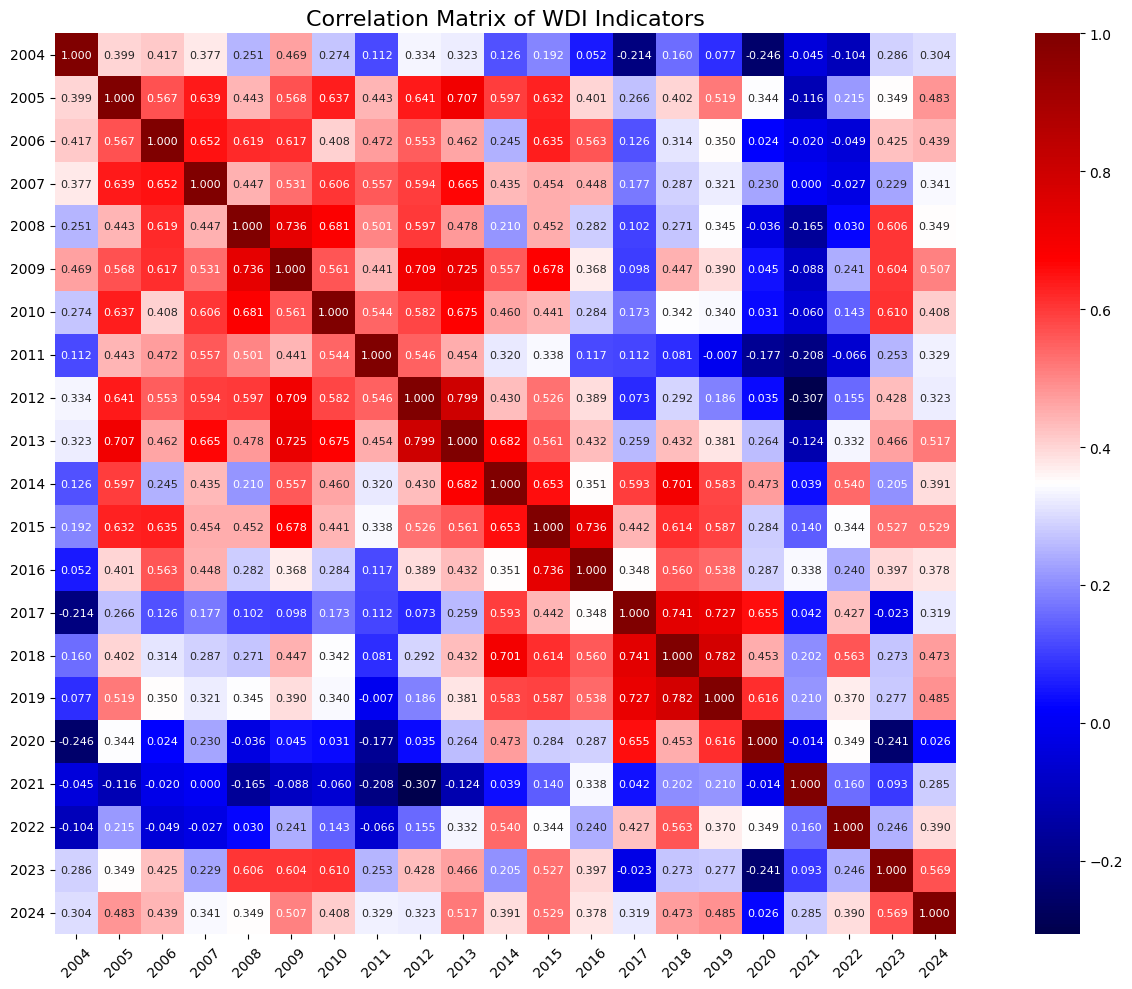

In [208]:
# correlation matrix plot
corr_matrix = clean_wdi.drop(['Country Code', 'Pre_Crisis_Growth (2004-2008)_y', 
                             'Recuperation_Growth (2009-2013)_y', 
                             'Stability_Growth (2014-2018)_y', 
                             'Recent_Growth (2019-2024)_y', 'Group'], axis=1).corr()

plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, 
            cmap="seismic", 
            fmt=".3f",
            annot=True,
            annot_kws={"size": 8},
            square=True,
            cbar=True)
plt.title('Correlation Matrix of WDI Indicators', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [175]:
# Function with group & beta-coeficient
def plot_beta_convergence(
    data: pd.DataFrame, 
    x_col: str, 
    y_col: str, 
    x_label: str, 
    y_label: str, 
    title: str
) -> None:

    plt.figure(figsize=(10, 6))
    colors = {'Emerging': 'blue', 'Developed': 'orange'}
    groups = ['Emerging', 'Developed']

    for group in groups:
        sett = data[data['Group'] == group]
        X = sett[[x_col]]
        y = sett[y_col]

        model = LinearRegression().fit(X, y)

        plt.scatter(X, y, label=f'{group} data', color=colors[group], alpha=0.5)
        plt.plot(X, model.predict(X), linestyle='-', color=colors[group], 
                 label=f'{group} (β = {model.coef_[0]:.2f})')

    plt.title(title, fontsize=16, pad=15)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend()
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()


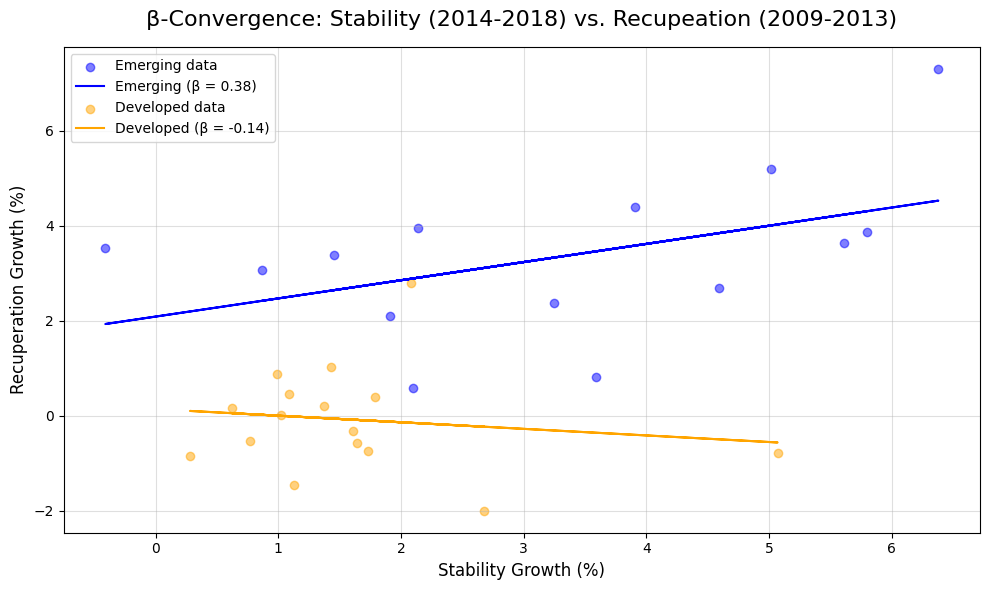

In [176]:
# First plot
plot_beta_convergence(
    clean_wdi, 
    'Stability_Growth (2014-2018)_y', 'Recuperation_Growth (2009-2013)_y',
    'Stability Growth (%)', 'Recuperation Growth (%)',
    'β-Convergence: Stability (2014-2018) vs. Recupeation (2009-2013)'
)

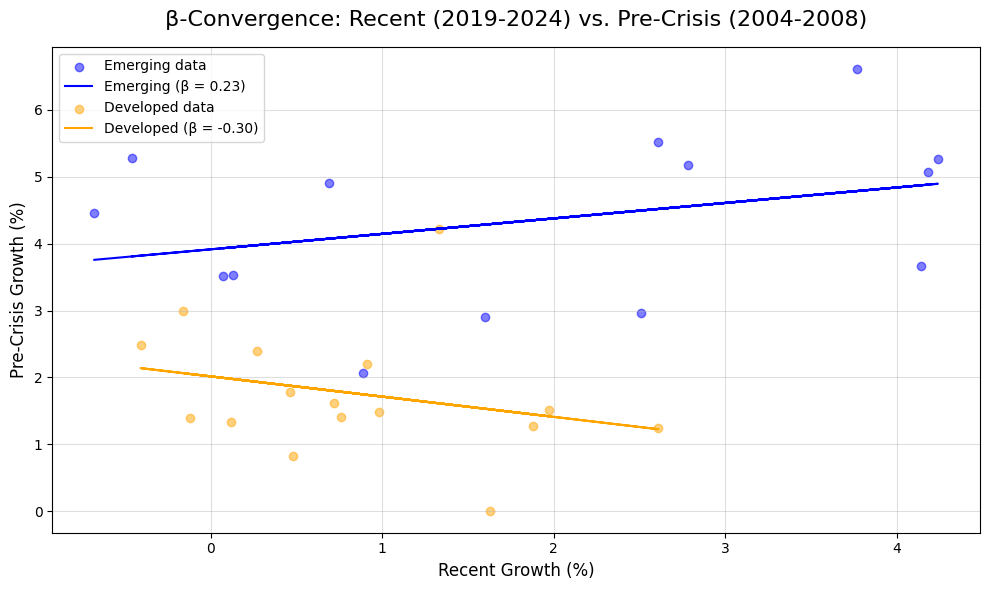

In [177]:
# Second plot
plot_beta_convergence(
    clean_wdi, 
    'Recent_Growth (2019-2024)_y', 'Pre_Crisis_Growth (2004-2008)_y',
    'Recent Growth (%)', 'Pre-Crisis Growth (%)',
    'β-Convergence: Recent (2019-2024) vs. Pre-Crisis (2004-2008)'
)

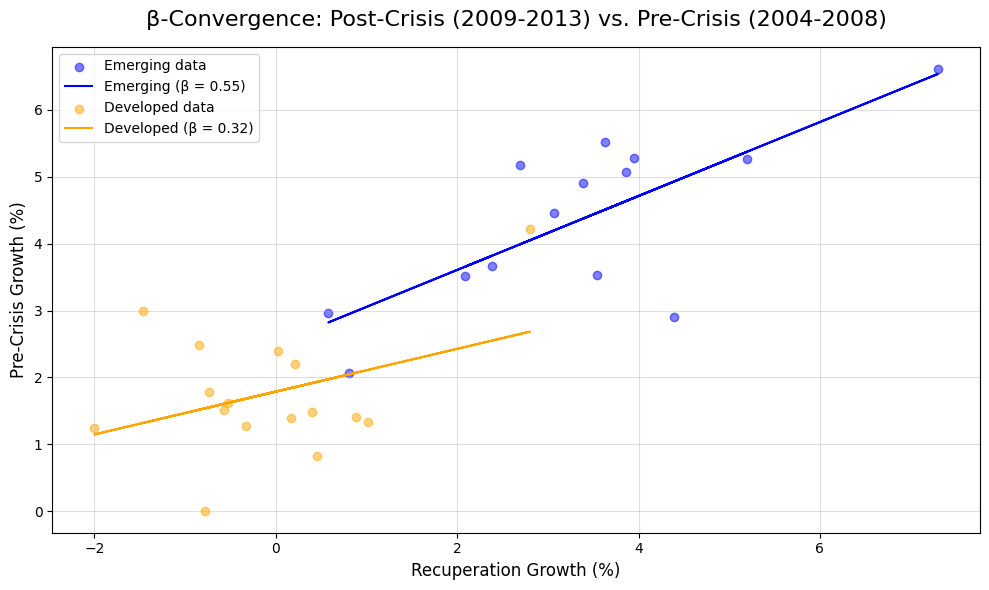

In [178]:
# Third plot
plot_beta_convergence(
    clean_wdi, 
    'Recuperation_Growth (2009-2013)_y', 'Pre_Crisis_Growth (2004-2008)_y',
    'Recuperation Growth (%)', 'Pre-Crisis Growth (%)',
    'β-Convergence: Post-Crisis (2009-2013) vs. Pre-Crisis (2004-2008)'
)